In [1]:
#Importing neccesary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, adjusted_rand_score, silhouette_score
from scipy.stats import mode
from sklearn.decomposition import PCA
from scipy import stats
from collections import Counter


In [2]:
#Load the dataset
df = pd.read_csv("german_credit_data.csv")
df.head(5)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [4]:
# Handle missing values (replace 'NA' with 'unknown')
df.loc[:, 'Saving accounts'] = df['Saving accounts'].fillna(df['Saving accounts'].mode()[0])  # Replace NA's with mode
df.loc[:, 'Checking account'] = df['Checking account'].fillna(df['Checking account'].mode()[0])  # Replace NA's with mode

In [6]:
# Handling outliers using Z-score
# Z-score method to identify outliers (Z > 3 or Z < -3)
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))  # Select the numeric columns
df_no_outliers = df[(z_scores < 3).all(axis=1)]  # Trace with Z-scores greater than 3

In [7]:
# Prepare target variable for checking
y_true = ((df_no_outliers['Credit amount'] > (df_no_outliers['Credit amount'].mean())) &
          (df_no_outliers['Duration'] > df_no_outliers['Duration'].mean())).astype(int)

In [9]:
# Encoding the categorical columns using label encoder
categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in categorical_cols:
    le = LabelEncoder()
    df_no_outliers.loc[:, col] = le.fit_transform(df_no_outliers[col].astype(str))

In [10]:
features = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Credit amount', 'Duration']
X = df_no_outliers[features]
# Standardizing the columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Applying feature extraction technique PCA
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [12]:
# KMeans Clustering
kmeans = KMeans(n_clusters=2, n_init=20, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca)

In [13]:
# GMM Clustering
gmm = GaussianMixture(n_components=2, random_state=42)
y_gmm = gmm.fit_predict(X_pca)

In [15]:
# Ensemble method by Majority Voting
ensemble_pred = np.array([Counter([y_kmeans[i], y_gmm[i]]).most_common(1)[0][0] for i in range(len(y_kmeans))])
# Here we calculate the majority vote of both KMeans and GMM predictions.

In [16]:
# Check the distribution of labels from the ensemble
print("Ensemble label distribution:", np.bincount(ensemble_pred))

Ensemble label distribution: [673 285]


In [17]:

def evaluate_clustering(y_pred, y_true, method_name):
    labels = np.zeros_like(y_pred)
    for i in range(2):
        mask = (y_pred == i)
        labels[mask] = mode(y_true[mask], keepdims=False).mode

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, labels)
    print(f"Confusion Matrix for {method_name}:\n{conf_matrix}")

    # Accuracy, Precision, Recall, F1 Score
    print(f"Accuracy:  {accuracy_score(y_true, labels):.4f}")
    print(f"Precision: {precision_score(y_true, labels):.4f}")
    print(f"Recall:    {recall_score(y_true, labels):.4f}")
    print(f"F1 Score:  {f1_score(y_true, labels):.4f}")

# Evaluate Ensemble
print("=== Ensemble (KMeans + GMM) Clustering Evaluation ===")
evaluate_clustering(ensemble_pred, y_true, "Ensemble (KMeans + GMM)")

=== Ensemble (KMeans + GMM) Clustering Evaluation ===
Confusion Matrix for Ensemble (KMeans + GMM):
[[632  78]
 [ 41 207]]
Accuracy:  0.8758
Precision: 0.7263
Recall:    0.8347
F1 Score:  0.7767


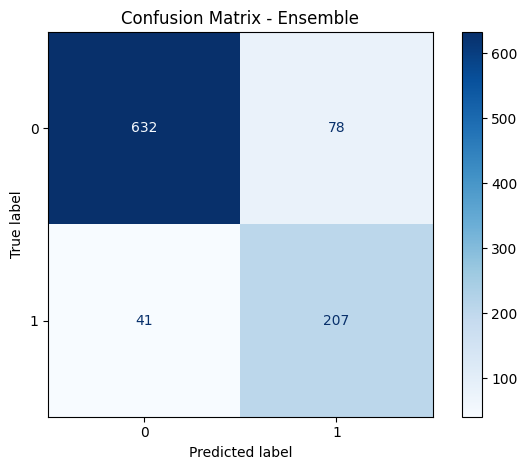

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

# Recalculate relabeled predictions
relabeled = np.zeros_like(ensemble_pred)
for i in range(2):
    mask = (ensemble_pred == i)
    relabeled[mask] = mode(y_true[mask], keepdims=False).mode

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true, relabeled, cmap="Blues")
plt.title("Confusion Matrix - Ensemble")
plt.tight_layout()
plt.show()


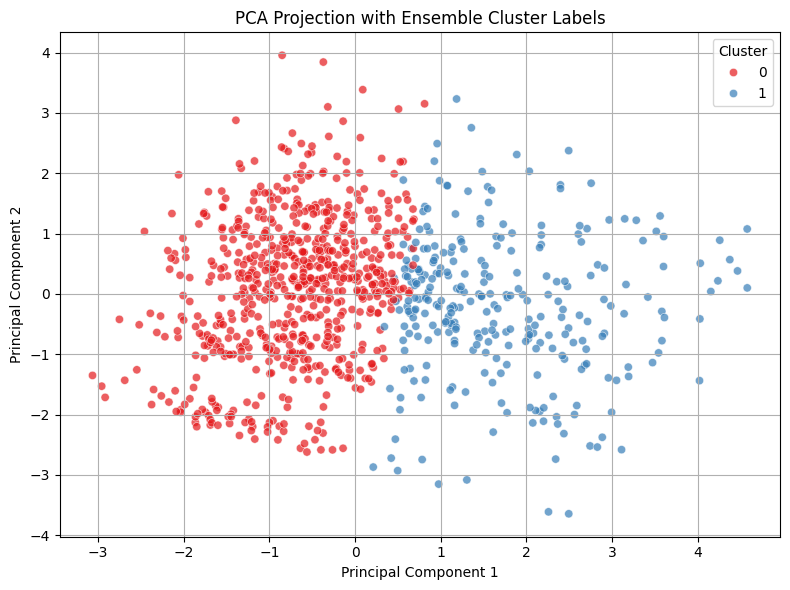

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot PCA-reduced features with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=ensemble_pred, palette="Set1", alpha=0.7)
plt.title("PCA Projection with Ensemble Cluster Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
import joblib

joblib.dump(kmeans, 'kmeans_model.joblib')
joblib.dump(gmm, 'gmm_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(pca, 'pca_model.joblib')

['pca_model.joblib']